# Automatic Hyperparameter Tuning

In this notebook we show how the `franken` library can be used to automatically find
the best hyperparameters (HPs) for fitting potential functions on a given dataset. The HP
search procedure is a simple grid-search over
 1. The kernel parameters (e.g length-scale, polynomial degree, ...)
 2. The solver parameters (e.g. force-weight, ridge penalty, ...)

This tuning procedure can be equivalently run using the code from this notebook, or from
the command-line using the `franken.autotune` command and specifying all options on the CLI.

This notebook is also available on [Google colab](https://colab.research.google.com/drive/1WOtoad4ju3TfpYFYBomB5KT2TmQ-OMxc?usp=sharing) for easy running.

In [1]:
try:
    import franken
except ImportError:
    %pip install franken[mace]
    import franken

In [2]:
import json

import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

from franken.autotune import autotune
from franken.config import MaceBackboneConfig, GaussianRFConfig, DatasetConfig, SolverConfig, HPSearchConfig, AutotuneConfig

/home/lbonati@iit.local/software/miniforge3-mamba/envs/franken/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


The process of running `autotune` is simple: first initialize all configuration objects. These will also include the definition of the hyperparameter search-space.
Then simply pass all objects to `autotune` which will run the training algorithm for each hyperparameters setting and figure out which one performs the best.
For this to work it is very important to provide a **validation dataset** which is different from the training set. The "water" dataset we use in the notebook also comes with a pre-defined validation split.

The equivalent `franken.autotune` command to the configuration defined here is:
```bash
franken.autotune \
    --dataset-name "water" --max-train-samples 8 \
    --l2-penalty="(-10, -5, 5, log)" \
    --force-weight="(0.01, 0.99, 5, linear)" \
    --seed 42 \
    --jac-chunk-size 64 \
    --run-dir "./results" \
    --backbone=mace --mace.path-or-id "mace_mp/small" --mace.interaction-block 2 \
    --rf=gaussian --gaussian.num-rf 512 --gaussian.length-scale="[10.0, 15.0]"
```

The GNN and dataset configurations are fixed. We use just 8 training samples to reduce the computation time for CoLab, but if you run this locally you can increase it.

In [3]:
gnn_config = MaceBackboneConfig(
    path_or_id="MACE-L0",
    interaction_block=2,
)
dataset_cfg = DatasetConfig(name="water", max_train_samples=8)

Backbone ID 'MACE-L0' is deprecated; use 'mace_mp/small' instead.


We use Gaussian random features to run the automatic tuning on the length-scale parameter. `autotune` will test values 5, 10 and 20.

In [4]:
rf_config = GaussianRFConfig(
    num_random_features=512,
    length_scale=HPSearchConfig(values=[10.0, 15.0, 20.0, 25.0, 30.0]),
    rng_seed=42,  # for reproducibility
)

The solver parameters are less expensive to iterate over, so we can use a finer grid.
For the `l2_penalty` HP we will test 5 logarithmically-spaced values between $10^{-10}$ and $10^{-5}$, and for the `force_weight` HP we will test 5 linearly-spaced values between 0.01 and 0.99.

In [5]:
solver_cfg = SolverConfig(
    l2_penalty=HPSearchConfig(start=-10, stop=-5, num=5, scale='log'),  # equivalent of numpy.logspace
    force_weight=HPSearchConfig(start=0.01, stop=0.99, num=5, scale='linear'),  # equivalent of numpy.linspace
)

Finally all configurations are grouped together and we run `autotune`.
Note the `run_dir` setting: this is where the logs and models will be saved.

In [6]:
autotune_cfg = AutotuneConfig(
    dataset=dataset_cfg,
    solver=solver_cfg,
    backbone=gnn_config,
    rfs=rf_config,
    seed=42,
    jac_chunk_size='auto',
    run_dir="./results",
)

run_path = autotune(autotune_cfg)

console_logging_level: INFO
dtype: float64
jac_chunk_size: auto
rf_normalization: leading_eig
run_dir: ./results
save_every_model: False
save_fmaps: False
scale_by_species: True
seed: 42
backbone:
    family: mace
    interaction_block: 2
    path_or_id: mace_mp/small
dataset:
    max_train_samples: 8
    name: water
    test_path: null
    train_path: null
    val_path: null
rfs:
    length_scale:
      num: null
      scale: null
      start: null
      stop: null
      value: null
      values:
      - 10.0
      - 15.0
      - 20.0
      - 25.0
      - 30.0
    num_random_features: 512
    rf_type: gaussian
    rng_seed: 42
    use_offset: true
solver:
    force_weight:
      num: 5
      scale: linear
      start: 0.01
      stop: 0.99
      value: null
      values: null
    l2_penalty:
      num: 5
      scale: log
      start: -10
      stop: -5
      value: null
      values: null

2025-12-19 17:38:31.620 INFO (rank 0): Initializing default cache directory at /home/lbonati@iit

Computing dataset statistics: 100%|██████████| 8/8 [00:00<00:00, 16.35it/s]


2025-12-19 17:38:35.987 INFO (rank 0): jacobian chunk size automatically set to 16
2025-12-19 17:39:10.850 WARNING (rank 0): `leading_eig` normalization has high memory usage. If you encounter OOM errors try to disable it.
2025-12-19 17:39:58.731 INFO (rank 0): Trial   1 | rf_type: gaussian | num_random_features:   512   | length_scale: 10.000  | use_offset:  True   | rng_seed:   42    | Best trial 1 (energy 0.34 meV/atom - forces 25.9 meV/Ang)
2025-12-19 17:39:59.776 INFO (rank 0): jacobian chunk size automatically set to 16
2025-12-19 17:40:34.066 WARNING (rank 0): `leading_eig` normalization has high memory usage. If you encounter OOM errors try to disable it.
2025-12-19 17:41:21.248 INFO (rank 0): Trial   2 | rf_type: gaussian | num_random_features:   512   | length_scale: 15.000  | use_offset:  True   | rng_seed:   42    | Best trial 2 (energy 0.32 meV/atom - forces 25.3 meV/Ang)
2025-12-19 17:41:22.271 INFO (rank 0): jacobian chunk size automatically set to 16
2025-12-19 17:41:56

## Analysing the results

There are two main outputs from the autotune procedure: the model trained with the best hyperparameters, which is saved at `"results/best_ckpt.pt"` and the logs which describe the errors of all the models trained.
Here we analyze the error-log, and in the `molecular_dynamics` notebook we will use the trained model to perform some MD simulations.

In [7]:
# We load the full logs for all training runs and the logs for just the best model.
with open(run_path / "log.json", "r") as fh:
    all_logs = json.load(fh)
with open(run_path / "best.json", "r") as fh:
    best_log = json.load(fh)

In [8]:
best_ls = best_log["hyperparameters"]["random_features"]["length_scale"]
best_l2 = best_log["hyperparameters"]["solver"]["l2_penalty"]
best_fw = best_log["hyperparameters"]["solver"]["force_weight"]
print("Best hyperparameters: ")
print(f"\tLength-scale: {best_ls:.1f}")
print(f"\tL2 penalty: {best_l2:.2e}")
print(f"\tForce-weight: {best_fw:.3f}")


Best hyperparameters: 
	Length-scale: 30.0
	L2 penalty: 1.78e-09
	Force-weight: 0.010


To make the analysis easier we convert the json logs to pandas

In [9]:
logs_df = pd.json_normalize(all_logs)  # flattens nested dictionaries and converts to DataFrame
logs_df.head()

,checkpoint.hash,checkpoint.rf_weight_id,timings.cov_coeffs,timings.solve,metrics.train.energy_MAE,metrics.train.forces_MAE,metrics.train.energy_RMSE,metrics.train.forces_RMSE,metrics.train.forces_cosim,metrics.validation.energy_MAE,...,hyperparameters.franken.family,hyperparameters.random_features.rf_type,hyperparameters.random_features.num_random_features,hyperparameters.random_features.length_scale,hyperparameters.random_features.use_offset,hyperparameters.random_features.rng_seed,hyperparameters.input_scaler.scale_by_Z,hyperparameters.solver.force_weight,hyperparameters.solver.l2_penalty,hyperparameters.solver.dtype
0,14d1ed49d65bd928f253709dd0fca610,0,36.450956,0.047169,0.192285,19.683960,0.209606,25.196530,0.998432,0.352717,...,mace,gaussian,512,10.0,True,42,True,0.01,1.000000e-10,torch.float64
1,14d1ed49d65bd928f253709dd0fca610,1,36.450956,0.001591,0.187330,19.723096,0.206137,25.268286,0.998405,0.352315,...,mace,gaussian,512,10.0,True,42,True,0.01,1.778279e-09,torch.float64
2,14d1ed49d65bd928f253709dd0fca610,2,36.450956,0.001522,0.200415,21.006084,0.222287,27.113716,0.998108,0.350954,...,mace,gaussian,512,10.0,True,42,True,0.01,3.162278e-08,torch.float64
3,14d1ed49d65bd928f253709dd0fca610,3,36.450956,0.001497,0.232249,25.740241,0.293293,33.200991,0.997148,0.390190,...,mace,gaussian,512,10.0,True,42,True,0.01,5.623413e-07,torch.float64
4,14d1ed49d65bd928f253709dd0fca610,4,36.450956,0.001495,0.399496,38.685922,0.505118,49.830448,0.994437,0.578130,...,mace,gaussian,512,10.0,True,42,True,0.01,1.000000e-05,torch.float64


Since we have three different hyperparameters it's hard to visualize their behavior all at the same time.
We start by analyzing the behavior as the forces-weight changes from very low to very high, plotting the error on both forces and energy predictions.

Text(0, 0.5, 'Forces MAE [meV/A]')

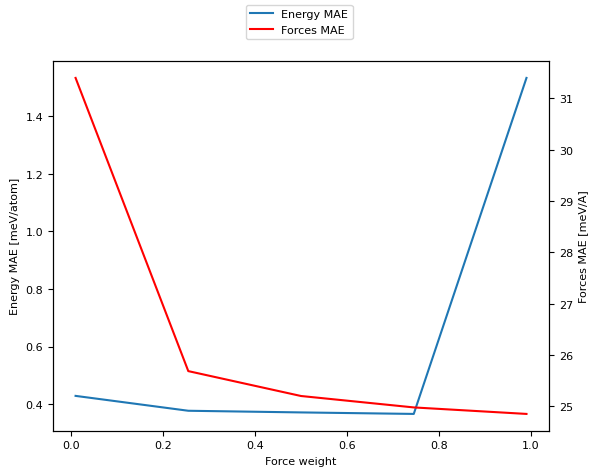

In [10]:
df_fw = logs_df[  # Fix the other two hyperparameters
    (logs_df["hyperparameters.random_features.length_scale"] == best_ls) &
    ((logs_df["hyperparameters.solver.l2_penalty"] - 5.62341325e-07).abs() < 1e-12)
]
df_fw = df_fw.sort_values("hyperparameters.solver.force_weight")
fig, ax = plt.subplots()
ax.plot(
    df_fw["hyperparameters.solver.force_weight"],
    df_fw["metrics.validation.energy_MAE"],
    label="Energy MAE"
)
ax2 = ax.twinx()
ax2.plot(
    df_fw["hyperparameters.solver.force_weight"],
    df_fw["metrics.validation.forces_MAE"],
    label="Forces MAE",
    c='r'
)
fig.legend(loc='upper center')
ax.set_xlabel("Force weight")
ax.set_ylabel("Energy MAE [meV/atom]")
ax2.set_ylabel("Forces MAE [meV/A]")

Next we analyze the behaviour of the length-scale and l2 penalty hyperparameters

Text(0, 0.5, 'L2 penalty')

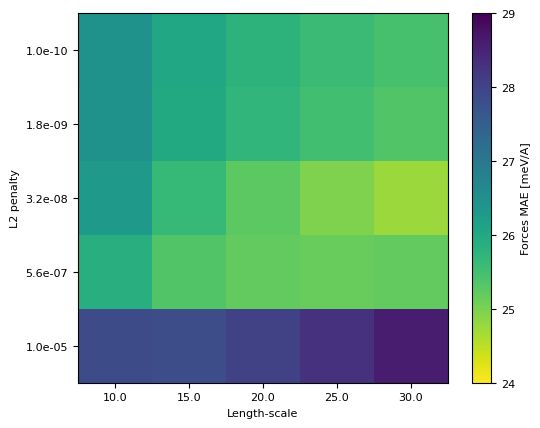

In [11]:
df_ker = logs_df[logs_df["hyperparameters.solver.force_weight"] == 0.5]
fig, ax = plt.subplots()
pivot = df_ker.pivot_table(
    index="hyperparameters.solver.l2_penalty",
    columns="hyperparameters.random_features.length_scale",
    values="metrics.validation.forces_MAE"
)
im = ax.imshow(pivot, norm=matplotlib.colors.Normalize(vmin=24, vmax=29), cmap="viridis_r")
cb = fig.colorbar(im)
cb.set_label("Forces MAE [meV/A]")
ax.set_xticks(range(len(pivot.columns)), pivot.columns)
ax.set_xlabel("Length-scale")
ax.set_yticks(range(len(pivot.index)), [f"{i:.1e}" for i in pivot.index])
ax.set_ylabel("L2 penalty")